<a href="https://colab.research.google.com/github/Philocreation/My_Deep_learning/blob/main/Template/korean_word_sequence_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

copy from : https://colab.research.google.com/github/dhrim/MDC_2021/blob/master/material/deep_learning/korean_word_sequence_classification.ipynb#scrollTo=5-pgao0HxEbn

# 한글 단어열 예측 

In [1]:
import pandas as pd
import numpy as np 
import re
import pickle

import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers 

import codecs
from tqdm import tqdm
import shutil

# tokenizer 설치 - Kkma

In [2]:
! pip install konlpy

     |████████████████████████████████| 19.4 MB 68.3 MB/s 
     |████████████████████████████████| 448 kB 69.3 MB/s 


In [3]:
from konlpy.tag import Okt

tokenizer = Okt()

In [4]:
poses = tokenizer.pos('토크나이징이 잘 되나요??')

In [5]:
tokens = []
for pos in poses:
  print(pos)
  tokens.append(pos[0])
print(tokens)

('토크', 'Noun')
('나', 'Josa')
('이징', 'Noun')
('이', 'Josa')
('잘', 'Verb')
('되나요', 'Verb')
('??', 'Punctuation')
['토크', '나', '이징', '이', '잘', '되나요', '??']


# 데이터 다운로드 

In [6]:
!wget https://github.com/dhrim/deep_learning_data/raw/master/movie_ratings.txt

--2022-01-17 05:14:53--  https://github.com/dhrim/deep_learning_data/raw/master/movie_ratings.txt
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/deep_learning_data/master/movie_ratings.txt [following]
--2022-01-17 05:14:54--  https://raw.githubusercontent.com/dhrim/deep_learning_data/master/movie_ratings.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19515078 (19M) [text/plain]
Saving to: ‘movie_ratings.txt’

movie_ratings.txt   100%[===================>]  18.61M  --.-KB/s    in 0.1s    

2022-01-17 05:14:55 (125 MB/s) - ‘movie_ratings.txt’ saved [19515078/19515078]



In [7]:
df = pd.read_table("movie_ratings.txt")
df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


# 데이터 섞기

In [8]:
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,id,document,label
0,9091227,완전 짱 역시 포켓몬이예요!!!,1
1,4645780,손발 오그라든다. 내가 본 최악의 로맨틱 코메디중 하나.,0
2,9271160,더디츠를 위하여 T.T 어린 더디츠 역할 소년의 그 맑고 맑은 표정이 잊혀지지 않네...,1
3,7626288,....,0
4,6998685,이 영화는 메세지가 확실하다. 하지만 마니아층에게만 통하는 영화이다.,1


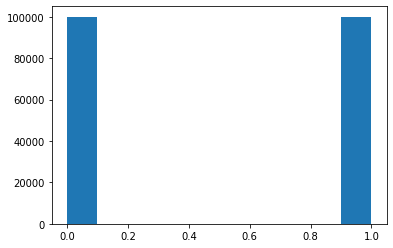

In [9]:
import matplotlib.pyplot as plt

plt.hist(df['label'])
plt.show()

# 입력과 출력 데이터 분리 

In [10]:
reviews = df.document.values.copy()
labels = df.label.values.copy()

In [11]:
print(reviews.shape)
print(labels.shape)

(200000,)
(200000,)


# 토큰나이징 

In [12]:
PAD = "[PAD]"
UNK = "[UNK]"

In [13]:
VOCA_SIZE = 4000 # 어휘 사전의 크기
SEQ_LENGTH = 128 # 리뷰 최대 길이 

In [14]:
from tqdm import tqdm 
from konlpy.tag import Okt 

def tokenize(reviews):
  tokenizer = Okt()
  tokenized = []
  # for review in tqdm(reviews):
  for review in reviews:
    review = str(review)
    # reivew = '꽤 괜찮은거 같아요~~'
    poses = tokenizer.pos(review)
    tokens = [pos[0] for pos in poses]
    # tokens = ['꽤', '괜찮은', '거', '같아요', '~~']
    tokens = tokens[:SEQ_LENGTH]
    tokenized.append(tokens)
  return tokenized 

In [15]:
print(len(reviews))

200000


In [16]:
tokenized_reviews = tokenize(reviews)

# 인코딩 

In [17]:
import collections
from collections import OrderedDict 

def build_index(tokenized_reviews):

  all_tokens = []
  for tokens in tokenized_reviews:
    all_tokens.extend(tokens)

  # 빈도 순으로 정열 
  counts = collections.Counter(all_tokens)
  sorted_tokens = sorted(all_tokens, key=counts.get, reverse=True) 

  # 단어 중복 삭제 
  sorted_tokens = list(OrderedDict.fromkeys(sorted_tokens)) 

  # voca 크기 이상의 단어는 버린다. 
  print("len(sorted_tokens) =", len(sorted_tokens))
  sorted_tokens = sorted_tokens[:VOCA_SIZE-2] # PAD, UNK 2개 
  sorted_tokens.insert(0, UNK)
  sorted_tokens.insert(0, PAD)
  print("len(sorted_tokens) = ", len(sorted_tokens))

  word2index = { word:index for index, word in enumerate(sorted_tokens)}
  index2word = { index:word for index, word in enumerate(sorted_tokens)}

  return word2index, index2word


def encode(tokenized_reviews, word2index):

  encoded_reviews = []
  for tokens in tokenized_reviews:
    # tokens = ['아', '더', '빙', '..', '진짜', '짜증', '나네', '요', '목소리']

    encoded = []
    for token in tokens:
      token = token if token in word2index else UNK
      encoded.append(word2index[token])

  # encoding = [2, 3, 4, 1, 5, 6, 7, 8, 9]

  # 길이가 모자라면 PAD(0)으로 채운다.
    padding_length = SEQ_LENGTH - len(encoded)
    encoded.extend([word2index[PAD]]*padding_length)
   # encoded = [2, 3, 4, 1, 5, 6, 7, 8, 9, 0, 0, 0, 0, 0, 0, 0, ... ]
    encoded_reviews.append(encoded)

  return encoded_reviews

word2index, index2word = build_index(tokenized_reviews)
encoded_reviews = encode(tokenized_reviews, word2index)

len(sorted_tokens) = 122829
len(sorted_tokens) =  4000


In [18]:
print(word2index)
print(index2word)

{'[PAD]': 0, '[UNK]': 1, '.': 2, '이': 3, '영화': 4, '의': 5, '..': 6, '가': 7, '에': 8, '을': 9, '...': 10, '도': 11, '들': 12, ',': 13, '는': 14, '를': 15, '은': 16, '너무': 17, '?': 18, '한': 19, '다': 20, '정말': 21, '적': 22, '만': 23, '진짜': 24, '!': 25, '점': 26, '으로': 27, '로': 28, '에서': 29, '연기': 30, '과': 31, '평점': 32, '것': 33, '최고': 34, '~': 35, '내': 36, '나': 37, '그': 38, '잘': 39, '와': 40, '인': 41, '안': 42, '이런': 43, '생각': 44, '스토리': 45, '못': 46, '왜': 47, '....': 48, '게': 49, '드라마': 50, '이다': 51, '감동': 52, '사람': 53, '1': 54, '하는': 55, '보고': 56, '하고': 57, '말': 58, '고': 59, '더': 60, '때': 61, '아': 62, 'ㅋㅋ': 63, '배우': 64, '감독': 65, '거': 66, '그냥': 67, '요': 68, '본': 69, '내용': 70, '재미': 71, '중': 72, '까지': 73, '뭐': 74, '!!': 75, '좀': 76, '보다': 77, '없는': 78, '쓰레기': 79, '시간': 80, '수': 81, '지': 82, '네': 83, '봤는데': 84, '사랑': 85, '작품': 86, '10': 87, '볼': 88, '할': 89, '없다': 90, '다시': 91, '하나': 92, '마지막': 93, '이건': 94, 'ㅋ': 95, '좋은': 96, '저': 97, '같은': 98, '정도': 99, '2': 100, '입니다': 101, '완전': 102, '있는': 103, 'ㅋㅋ

In [19]:
x = np.array(encoded_reviews)
print(x.shape)

y = labels
print(y.shape)

(200000, 128)
(200000,)


In [20]:
print(x)

[[ 102  166  135 ...    0    0    0]
 [1251    1    2 ...    0    0    0]
 [   1   15  323 ...    0    0    0]
 ...
 [ 466    1    1 ...    0    0    0]
 [1456 2240    1 ...    0    0    0]
 [ 877   22   41 ...    0    0    0]]


# 모델 학습

## train, test 분리 

In [21]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, shuffle=True)

In [22]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(160000, 128)
(160000,)
(40000, 128)
(40000,)


## 학습 실행 

In [23]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Bidirectional, LSTM 

EMBEDDING_SIZE = 64

model = Sequential()
model.add(Input(SEQ_LENGTH))
model.add(Embedding(VOCA_SIZE, EMBEDDING_SIZE))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64)))
model.add(Dense(250, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
model.summary()

model.fit(train_x, train_y, batch_size=32, epochs=5, validation_split=0.1)

loss, acc = model.evaluate(test_x,test_y)
print("loss=",loss)
print("acc=", acc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 64)           256000    
                                                                 
 batch_normalization (BatchN  (None, 128, 64)          256       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 250)               32250     
                                                                 
 batch_normalization_1 (Batc  (None, 250)              1000      
 hNormalization)                                                 
                                                        

# 분류 실행 

In [24]:
def do_classify(test_text):
  tokenized_text = tokenize([test_text])
  encoded_text = encode(tokenized_text, word2index)
  model_input = np.array(encoded_text)
  y_ = model.predict(model_input)
  predicted = "긍정" if y_>0.5 else "부정"

  print(test_text, "-->", predicted, ",score :", y_[0][0])

do_classify("여운이 많이 남는 영화")
do_classify("여운이 많이 남는 영화. 스토리 전개는 뻔함.")
do_classify("여운이 많이 남는 영화. 스토리 전개는 뻔함. 시간 때우기 용")
do_classify("여운이 많이 남는 영화. 스토리 전개는 뻔함. 시간 때우기 용, 비추.")

여운이 많이 남는 영화 --> 긍정 ,score : 0.9887748
여운이 많이 남는 영화. 스토리 전개는 뻔함. --> 긍정 ,score : 0.74641144
여운이 많이 남는 영화. 스토리 전개는 뻔함. 시간 때우기 용 --> 부정 ,score : 0.18241005
여운이 많이 남는 영화. 스토리 전개는 뻔함. 시간 때우기 용, 비추. --> 부정 ,score : 0.020680418
